In [188]:
# import packages 
import networkx as nx
import os
import pandas as pd
import tweepy
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib as matplotlib
from pyvis import network as net
import pickle

In [189]:
# paste where the final subset of your data can be found. 

path = "/Users/lukas/Documents/Uni/Copenhagen/Year 1/Block 4/ASDS II/Exam/github/ASDS2/Notebooks/data/"

df = pd.read_csv(path+ "bushfire_subset3.csv")
df.shape

(2988, 21)

In [88]:
# drop tweets that are not retweeted
df_retweet = df.dropna(subset=["retweet_name"])

In [89]:
df_retweet.shape

(1192, 21)

In [193]:
# code retweets as 1 if they are retweeted from a MP in the DF. else 0

df_retweet["retweetet"] = [1 if x in set(df_retweet["screen_name"]) else 0 for x in df_retweet["retweet_name"]]

<ipython-input-193-80864ae65f1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweet["retweetet"] = [1 if x in set(df_retweet["screen_name"]) else 0 for x in df_retweet["retweet_name"]]


In [194]:
# sum of intra-df retweets 
df_retweet.retweetet.sum()

429

In [195]:
# delete retweets from non-mps

df_retweet = df_retweet[df_retweet["retweetet"]==1]

df_retweet.reset_index(inplace=True)

In [196]:
# group df and get counts of how often people retweeted each other (as weights)

df_rt = df_retweeted.groupby(["screen_name", "retweet_name"]).size().reset_index(name='simple_count')

df_rt["count"] = df_rt["simple_count"]**0.6

print(df_rt.shape)
df_rt.head(5)

(173, 4)


,screen_name,retweet_name,simple_count,count
0,ALeighMP,AlboMP,1,1.0
1,ALeighMP,AliciaPayneMP,1,1.0
2,AlanTudgeMP,DarrenChesterMP,1,1.0
3,AlanTudgeMP,GregHuntMP,1,1.0
4,AlanTudgeMP,JoshFrydenberg,1,1.0


## Graph using networkx

Graph has 73 nodes with 173 edges


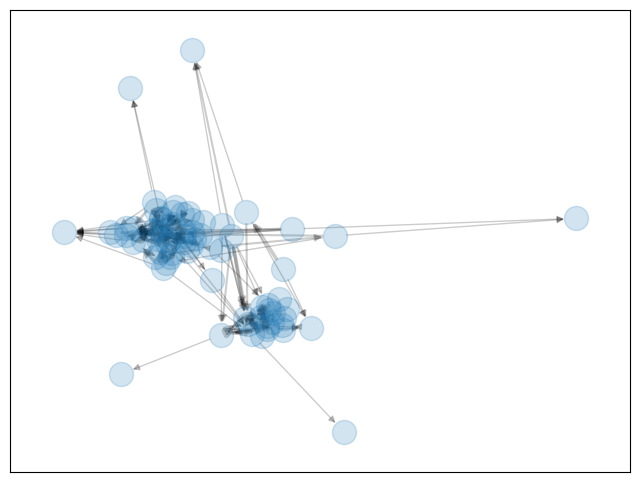

In [198]:


G = nx.from_pandas_edgelist(df_rt,'screen_name','retweet_name',
                            edge_attr="count",
                            create_using = nx.DiGraph())

pos = nx.spring_layout(G, k=0.3)

edge_w = [i['count'] for i in dict(G.edges).values()]

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (8, 6)})

nx.draw_networkx(G, edge_color="black",
                 with_labels=False,
                 alpha=0.2,
                 width=edge_w
                )

print(f"Graph has {nx.number_of_nodes(G)} nodes with {nx.number_of_edges(G)} edges")
plt.show()

## Network using PyVis

In [167]:
# create df with screen name and party
df_party = df_retweeted.drop_duplicates("screen_name")

df_party.drop(['index', 'Unnamed: 0', 'user_id', 'tweet_id',
       'created_at', 'full_text', 'favorite_count', 'retweet_count',
       'retweet_name', 'in_reply_to_screen_name', 'hashtags', 'user_mentions',
       'url', 'image_url', 'name', 'legislative_period', 'stems',
       'stems_bigrams', 'final_text', 'index_col', 'retweetet'], axis=1, inplace=True)


In [139]:
# Create nodelist
a1 = df_rt["screen_name"].tolist()
a2 = df_rt["retweet_name"].tolist()
node_list = list(set(a1 + a2))

In [205]:
# create a df of the node list and the corresponding party

node_df = pd.DataFrame(node_list, columns= ["screen_name"])

node_df = node_df.merge(df_party, how='outer', on='screen_name')

print("Parties in node list:", "\n", node_df.party.unique())
print("-"*20, "\n", "-"*20)

node_dict = dict(zip(node_df.screen_name, node_df.party))

for i, y in node_dict.items():
    print("name:", i,"-"*5,"party:",y)

# manually add party membership for the those we didnt catch
node_dict["DarrenChesterMP"] = "The Nationals"
node_dict["Josh4Freo"] = 'Australian Labor Party'
node_dict["AliciaPayneMP"] = 'Australian Labor Party'
node_dict["fitzhunter"] = 'Australian Labor Party'
node_dict["billshortenmp"] = 'Australian Labor Party'
node_dict["DanTehanWannon"] = 'Liberal Party of Australia'

Parties in node list: 
 ['Liberal Party of Australia' 'Australian Labor Party' nan
 'Liberal National Party of Queensland' 'The Nationals']
-------------------- 
 --------------------
name: ScottMorrisonMP ----- party: Liberal Party of Australia
name: lukejgosling ----- party: Australian Labor Party
name: AnneWerriwa ----- party: Australian Labor Party
name: andrewjgiles ----- party: Australian Labor Party
name: stevegeorganas ----- party: Australian Labor Party
name: terrimbutler ----- party: Australian Labor Party
name: DarrenChesterMP ----- party: nan
name: JulieOwensMP ----- party: Australian Labor Party
name: MariaVamvakinou ----- party: Australian Labor Party
name: FionaMartinMP ----- party: Liberal Party of Australia
name: karenandrewsmp ----- party: Liberal National Party of Queensland
name: AlboMP ----- party: Australian Labor Party
name: tanya_plibersek ----- party: Australian Labor Party
name: BOConnorMP ----- party: Australian Labor Party
name: markdreyfusQCMP ----- party: 

In [206]:
# Create nodelist
a1 = df_rt["screen_name"].tolist()
a2 = df_rt["retweet_name"].tolist()
node_list = list(set(a1 + a2))


# Edgedata as tuples
tuples = [tuple(x) for x in df_rt[["screen_name","retweet_name", "count"]].values]

# Create network
nt = net.Network(notebook=True,
                     height = "700px",
                     width = "700px",
                     bgcolor = "#f6f2e9")

# Add nodes and edges to network

for name, party in node_dict.items():
    if party == "Liberal Party of Australia":
        color = "yellow"
        nt.add_node(name, title=name, color=color)
    elif party == "Australian Labor Party":
        color = "red"
        nt.add_node(name, title=name, color=color)
    elif party == "Liberal National Party of Queensland":
        color = "orange"
        nt.add_node(name, title=name, color=color)
    else: 
        color = "brown"
        nt.add_node(name, title=name, color=color)



#for i in node_list:
#    nt.add_node(i, title=i)
nt.add_edges(tuples)

nt.force_atlas_2based()

# Save and show
nt.show('retweet_network.html')